# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset

import IPython.display as ipd

import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as transforms

In [2]:
# Check if GPU is available
print("Is GPU available? ", torch.cuda.is_available())

# Print GPU name
if torch.cuda.is_available():
    print("GPU: ", torch.cuda.get_device_name(0))

Is GPU available?  True
GPU:  NVIDIA GeForce RTX 3070


# Exact Dataset Path

In [3]:
#from google.colab import drive
#drive.mount('/content/drive/')

# Replace with your actual dataset folder path
# Load the first dataset
dataset_path = r'C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset'
mendeley_dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\KUET Bangla Emotional Speech (KBES) Dataset"  # Replace with the actual path
fear_dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\North South Bangla Emotional Speech\Fear"
# Output path for reduced audio files
reduced_audio_path = r"C:\Users\Jim\Jupiter Projects\CSE499\Reduced_KBES_Dataset"  # Replace with your desired output path
augmented_audio_path = r"C:\Users\Jim\Jupiter Projects\CSE499\augmented_audios"

# KUET and BANGLASER mixing

Using device: cuda
B-SER: 1467 files loaded
Angry (High): 100 files
Angry (Low): 100 files
Disgust (High): 100 files
Disgust (Low): 100 files
Happy (High): 100 files
Happy (Low): 100 files
Neutral: 100 files
Sad (High): 100 files
Sad (Low): 100 files
KBES: 900 files loaded
Total samples: 2367
Label distribution: [343 506 506 506 306 200]
Train samples: 1656, Val samples: 237, Test samples: 474
Test set label distribution: [ 69 101 101 102  61  40]
Train batches: 52
Total parameters: 144134
Starting training...
Epoch 1, Loss: 1.3251, Val Accuracy: 0.5992
Epoch 2, Loss: 0.9224, Val Accuracy: 0.6034
Epoch 3, Loss: 0.7972, Val Accuracy: 0.6034
Epoch 4, Loss: 0.6192, Val Accuracy: 0.5570
Epoch 5, Loss: 0.5499, Val Accuracy: 0.6456
Epoch 6, Loss: 0.5194, Val Accuracy: 0.6203
Epoch 7, Loss: 0.4084, Val Accuracy: 0.6118
Epoch 8, Loss: 0.3168, Val Accuracy: 0.6709
Epoch 9, Loss: 0.2396, Val Accuracy: 0.7173
Epoch 10, Loss: 0.2016, Val Accuracy: 0.6624
Epoch 11, Loss: 0.1495, Val Accuracy: 0.683

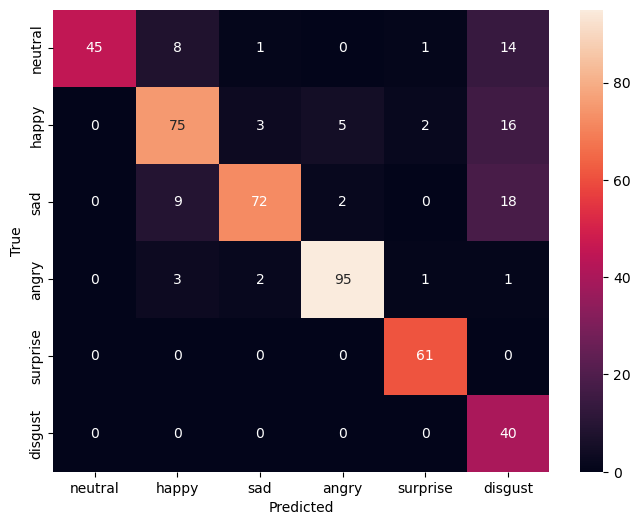

Weighted Accuracy: 0.8186


In [4]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preprocessing
def standardize_audio(file_path, target_length=3, sample_rate=16000):
    waveform, sr = librosa.load(file_path, sr=sample_rate)
    target_samples = int(target_length * sample_rate)
    if len(waveform) < target_samples:
        waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
    else:
        waveform = waveform[:target_samples]
    return waveform, sr

def load_bser_dataset(dataset_path, target_length=3):
    paths, labels = [], []
    label_mapping = {"01": "happy", "02": "sad", "03": "angry", "04": "surprise", "05": "neutral"}
    for actor in range(1, 35):
        actor_path = os.path.join(dataset_path, f"Actor {actor:02d}")
        if not os.path.isdir(actor_path):
            print(f"Skipping {actor_path}: not a directory")
            continue
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                parts = file.split("-")
                if len(parts) < 3 or parts[2] not in label_mapping:
                    continue
                file_path = os.path.join(actor_path, file)
                waveform, _ = standardize_audio(file_path, target_length)
                paths.append(file_path)
                labels.append(label_mapping[parts[2]])
    print(f"B-SER: {len(paths)} files loaded")
    return paths, labels

def load_kbes_dataset(dataset_path, target_length=3):
    paths, labels = [], []
    label_mapping = {
        "Angry (High)": "angry", "Angry (Low)": "angry",
        "Happy (High)": "happy", "Happy (Low)": "happy",
        "Neutral": "neutral",
        "Sad (High)": "sad", "Sad (Low)": "sad",
        "Disgust": "disgust", "Disgust (High)": "disgust", "Disgust (Low)": "disgust"
    }
    for emotion_folder in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_folder)
        if not os.path.isdir(emotion_path):
            continue
        if emotion_folder not in label_mapping:
            print(f"Skipping unknown folder: {emotion_folder}")
            continue
        num_files = len([f for f in os.listdir(emotion_path) if f.endswith(".wav")])
        print(f"{emotion_folder}: {num_files} files")
        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)
                waveform, _ = standardize_audio(file_path, target_length)
                paths.append(file_path)
                labels.append(label_mapping[emotion_folder])
    print(f"KBES: {len(paths)} files loaded")
    return paths, labels

def extract_mfcc(file_path, sample_rate=16000, n_mfcc=40, n_frames=300):
    waveform, sr = librosa.load(file_path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=len(waveform)//(n_frames-1))
    if mfcc.shape[1] < n_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, n_frames - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :n_frames]
    return mfcc

def precompute_mfccs(paths, save_dir, sample_rate=16000, n_mfcc=40, n_frames=300):
    os.makedirs(save_dir, exist_ok=True)
    mfcc_paths = []
    for i, file_path in enumerate(paths):
        save_path = os.path.join(save_dir, f"mfcc_{i}.npy")
        if not os.path.exists(save_path):
            mfcc = extract_mfcc(file_path, sample_rate, n_mfcc, n_frames)
            np.save(save_path, mfcc)
        mfcc_paths.append(save_path)
    return mfcc_paths

class PrecomputedAudioDataset(Dataset):
    def __init__(self, mfcc_paths, labels, label_map):
        self.mfcc_paths = mfcc_paths
        self.labels = [label_map[l] for l in labels]

    def __len__(self):
        return len(self.mfcc_paths)

    def __getitem__(self, idx):
        mfcc = np.load(self.mfcc_paths[idx])
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Model Definition
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv1d(40, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False)
        )
        self.pool1 = nn.MaxPool1d(2)
        self.block2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.pool2 = nn.AdaptiveMaxPool1d(31)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        return x

class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNTransformerHybrid, self).__init__()
        self.cnn = CNNBackbone()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, dim_feedforward=256, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Linear(31 * 128, num_classes)

    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        combined = torch.cat((cnn_out.permute(0, 2, 1), transformer_out), dim=-1)
        combined = combined.reshape(combined.size(0), -1)
        out = self.fc(combined)
        return out

# Training and Evaluation
def train_model(model, train_loader, val_loader, num_epochs=50):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())
        val_accuracy = accuracy_score(all_labels, all_preds)
        scheduler.step(val_accuracy)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    return model

def evaluate_model(model, test_loader, label_map):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    unique_labels = np.unique(all_labels)
    label_map_inv = {v: k for k, v in label_map.items()}
    present_classes = [label_map_inv[i] for i in unique_labels]

    print("Classes present in test set:", present_classes)
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=unique_labels, 
        target_names=present_classes, 
        zero_division=0
    ))

    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_counts = np.bincount(all_labels, minlength=len(label_map))
    class_acc = [cm[i, i] / class_counts[unique_labels[i]] for i in range(len(unique_labels)) if class_counts[unique_labels[i]] > 0]
    weighted_acc = np.sum(class_acc * class_counts[unique_labels] / len(all_labels))
    print(f"Weighted Accuracy: {weighted_acc:.4f}")

# Main Execution
if __name__ == "__main__":
    dataset_path = dataset_path  # Replace with actual path
    mendeley_dataset_path = mendeley_dataset_path  # Replace with actual path
    bser_paths, bser_labels = load_bser_dataset(dataset_path)
    kbes_paths, kbes_labels = load_kbes_dataset(mendeley_dataset_path)
    all_paths = bser_paths + kbes_paths
    all_labels = bser_labels + kbes_labels
    label_map = {"neutral": 0, "happy": 1, "sad": 2, "angry": 3, "surprise": 4, "disgust": 5}

    save_dir = "mfcc_cache"
    all_mfcc_paths = precompute_mfccs(all_paths, save_dir)
    dataset = PrecomputedAudioDataset(all_mfcc_paths, all_labels, label_map)
    print(f"Total samples: {len(dataset)}")

    numerical_labels = [label_map[label] for label in all_labels]
    print(f"Label distribution: {np.bincount(numerical_labels)}")

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_val_idx, test_idx = next(sss.split(all_mfcc_paths, numerical_labels))
    train_val_paths = [all_mfcc_paths[i] for i in train_val_idx]
    train_val_labels = [numerical_labels[i] for i in train_val_idx]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
    train_idx, val_idx = next(sss.split(train_val_paths, train_val_labels))

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
    test_labels = [dataset[i][1].item() for i in test_idx]
    print(f"Test set label distribution: {np.bincount(test_labels)}")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0, pin_memory=True)
    print(f"Train batches: {len(train_loader)}")

    torch.cuda.empty_cache()
    model = CNNTransformerHybrid(num_classes=6).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    print("Starting training...")
    model = train_model(model, train_loader, val_loader, num_epochs=50)
    evaluate_model(model, test_loader, label_map)

In [5]:
def clear_memory():
    import gc
    import torch

    # Clear GPU memory (PyTorch)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Clear RAM memory
    gc.collect()

# Call the function
clear_memory()